# Model Training Iteration 2
Model training here contains:
- Dataset only sourced from the internet 
- CustomDataGenerator to introduce data augmentation 
- Simple CNN architecture  

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.utils import shuffle
from modules.data_preprocessing import DataGenerator,split_dataset
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D

2024-03-17 00:48:53.302304: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-17 00:48:53.350514: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-17 00:48:53.350566: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-17 00:48:53.350582: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-17 00:48:53.359259: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-17 00:48:53.360403: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

## Constants

In [5]:
TARGET_WORD='marvin'
SEED= 324234
SPEECH_DATA='/src/voice_power/audio_data'
train_ratio,val_ratio,test_ratio=0.8,0.1,0.1
BATCH_SIZE=32
VAL_BATCH_SIZE=8
IMG_WIDTH=43
IMG_HEIGHT=99
NOISE_FLOOR=0.1

## Processing data 

Data Augmentation is introduced through the use of the class "DataGenerator" imported from modules/data_preprocessing.py. This is a custom data generator that at a high level performs the following: 
- Takes in filenames and reads the associated audio wav file
- Perform downsampling to solve class imbalance, every epoch the non-target class samples vary. 
- Isolates that speech component of the audio wave form and performs a random temporal shift
- Add random backhround noise that is also scaled randomly
- Computes the mel spectrogram of the processed audio 

This custom data generator is akin to the ImageDataGenerator from keras but is better suited for the needs of this project. 

In [6]:
def list_subfolders(folder_path):
    subfolders = [f.path[len(folder_path)+1:] for f in os.scandir(folder_path) if f.is_dir()]
    return subfolders

words = list_subfolders(SPEECH_DATA)
classes=[word for word in words if "_" not in word]
valid_filenames=np.load('/src/voice_power/valid_filenames.npy')

train_filenames,val_filenames,test_filenames=split_dataset(valid_filenames,
                                                           TARGET_WORD,
                                                           classes,
                                                           train_ratio=train_ratio,
                                                           val_ratio=val_ratio,
                                                           test_ratio=test_ratio)

#Initializing custom data generator that augments the dataset.
datagen_train=DataGenerator(filenames=train_filenames,
                            classes=classes,
                            data_folder=SPEECH_DATA,
                            noise_floor=NOISE_FLOOR,
                            target=TARGET_WORD,
                            batch_size=BATCH_SIZE,
                            training=True)

datagen_val=DataGenerator(filenames=val_filenames,
                          classes=classes,
                          data_folder=SPEECH_DATA,
                          noise_floor=NOISE_FLOOR,
                          target=TARGET_WORD,
                          batch_size=VAL_BATCH_SIZE,
                          training=False)

## Model Achitecture

In [7]:
def build_model(kernal_reg=0.0001):
    tf.keras.backend.clear_session()
 
    model = Sequential([
        Conv2D(4, 3, 
               padding='same',
               activation='relu',
               kernel_regularizer=regularizers.l2(kernal_reg),
               name='conv_layer1',
               input_shape=(IMG_WIDTH, IMG_HEIGHT, 1)),
        MaxPooling2D(name='max_pooling1', pool_size=(2,2)),
        Conv2D(4, 3, 
               padding='same',
               activation='relu',
               kernel_regularizer=regularizers.l2(kernal_reg),
               name='conv_layer2'),
        MaxPooling2D(name='max_pooling2', pool_size=(2,2)),
        Flatten(),
        Dropout(0.2),
        Dense(
            40,
            activation='relu',
            kernel_regularizer=regularizers.l2(kernal_reg),
            name='hidden_layer1'
        ),
        Dense(
            1, 
            activation='sigmoid',
            kernel_regularizer=regularizers.l2(kernal_reg),
            name='output'
        )
    ])
    return model


In [8]:
model=build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_layer1 (Conv2D)        (None, 43, 99, 4)         40        
                                                                 
 max_pooling1 (MaxPooling2D  (None, 21, 49, 4)         0         
 )                                                               
                                                                 
 conv_layer2 (Conv2D)        (None, 21, 49, 4)         148       
                                                                 
 max_pooling2 (MaxPooling2D  (None, 10, 24, 4)         0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 960)               0         
                                                                 
 dropout (Dropout)           (None, 960)               0

## Training 

In [9]:
model=build_model()

epochs=60
validation_split=0.2
batch_size=16
validation_batch_size=8

model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_checkpoints",save_weights_only=True,save_best_only=True)

In [10]:
history=model.fit(x=datagen_train,
                  validation_data=datagen_val, 
                  epochs=epochs,
                  callbacks=[checkpoint_cb,early_stopping_cb]))


2024-03-17 00:50:47.609127: I tensorflow_io/core/kernels/cpu_check.cc:128] Your CPU supports instructions that this TensorFlow IO binary was not compiled to use: SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA


Epoch 1/60
79/79 [==============================] - 130s 2s/step - loss: 0.7092 - accuracy: 0.5779 - val_loss: 0.5858 - val_accuracy: 0.6875
Epoch 2/60
79/79 [==============================] - 113s 1s/step - loss: 0.5747 - accuracy: 0.7172 - val_loss: 0.4583 - val_accuracy: 0.8125
Epoch 3/60
79/79 [==============================] - 102s 1s/step - loss: 0.5084 - accuracy: 0.7702 - val_loss: 0.4146 - val_accuracy: 0.8059
Epoch 4/60
79/79 [==============================] - 106s 1s/step - loss: 0.4590 - accuracy: 0.7987 - val_loss: 0.3617 - val_accuracy: 0.8421
Epoch 5/60
79/79 [==============================] - 102s 1s/step - loss: 0.4341 - accuracy: 0.8113 - val_loss: 0.3279 - val_accuracy: 0.8618
Epoch 6/60
79/79 [==============================] - 102s 1s/step - loss: 0.3896 - accuracy: 0.8327 - val_loss: 0.2936 - val_accuracy: 0.8816
Epoch 7/60
79/79 [==============================] - 100s 1s/step - loss: 0.3611 - accuracy: 0.8509 - val_loss: 0.2629 - val_accuracy: 0.9211
Epoch 8/60
79

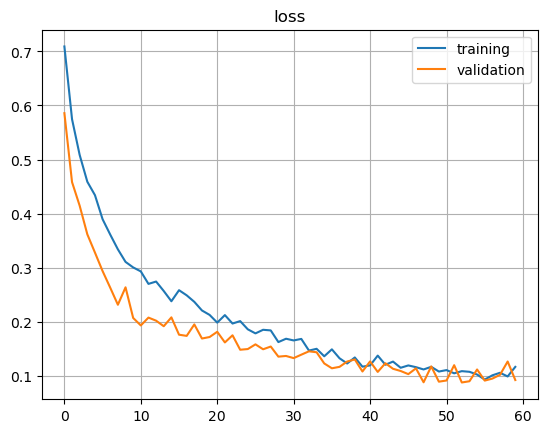

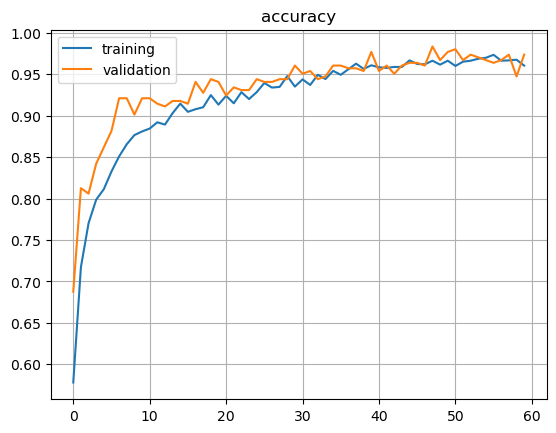

In [12]:
metrics=history.history
plt.plot(metrics['loss'],label='training')
plt.plot(metrics['val_loss'],label='validation')
plt.legend()
plt.title('loss')
plt.grid()
plt.show()

plt.plot(metrics['accuracy'],label='training')
plt.plot(metrics['val_accuracy'],label='validation')
plt.legend()
plt.title('accuracy')
plt.grid()
plt.show()


## Evaluating training and validation set results 

There is a significant improvement to the validation error going from 90% to 97% as a result of introducing data augmentation through the use of the custom data generator. In earlier epoches the validation accuracy is higher than the training accuracy, this can be atributed to the use of drop out in the model architecture.

## Next Steps
- Develop code to perform the real-time capturing and classification of audio.
- Consider introducing background noise by itself as a non-target class for training. It could help real-time detection. 